In [2]:

import pyvo as vo
import numpy as np
from astropy.coordinates import SkyCoord
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import astropy.units as u
import matplotlib.pyplot as plt
from astropy.utils.data import download_file
from astropy.io import fits
from astropy.table import Table
from photutils.aperture import CircularAperture, CircularAnnulus, aperture_photometry
from photutils.utils import calc_total_error
import pandas as pd
from scipy.spatial import KDTree
import json


from scipy.optimize import curve_fit
from photutils.detection import DAOStarFinder
from astropy.stats import mad_std, sigma_clipped_stats
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
import math

In [3]:
%matplotlib inline

# initialization of flux values so i can debug:


In [ ]:




####Defining the constants

#define coordinates	
ra= 359.45700000000016
dec= -32.592000000000013
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
print(pos)

# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")

#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table
im_table.to_table().colnames
for i in range(len(im_table)):
    print(im_table[i])


   #grab the x-ray sources for this galaxy
#import huge csv and grab the name and ra and dec needed for each source.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec', 'Gname_Modified','Gname_Homogenized']
g_huge = huge[columns]
g_huge[0:100]

#locate through merging
df1 = targetgals
df2 = g_huge

merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns = ['RA','Dec','Gname_Homogenized']
Xray_sources = merged_data[columns]
Xray_sources

# just want NGC 7793s sources
sources_7793 = Xray_sources.loc[Xray_sources['Gname_Homogenized'] == 'NGC 7793']
#sources_7793
#define the X-ray sources of NGC 7793
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values
#print(ra)

# defining a function to calculate the distances between two sources.
def dist(p1, p2):
    return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )

#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
    Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
    dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
    mask = dist_from_center <= radius # so that everything inside the radius receives a mask
    return mask

# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6 ,'w4':12.98 }
wavelengths = {'w1': 3.4 ,'w2': 4.6,'w3': 12,'w4': 22}

#define function to get flux density per unit frequency (energy units)
def flux_dens(net_flx, net_flx_err, wavelength):
    flux_density = (net_flx * 1e-23) * (3e10 / (wavelength*1e-4)**2)
    flux_density_unc = (net_flx_err * 1e-23) * (3e10 / (wavelength*1e-4)**2)
    return flux_density, flux_density_unc


##running the for loop over every image and doing aperture photometry on each one
#currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1
rows = []
for i in [0, 3, 2, 1]:  # Reverse order index
    band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase

    if band_id in band_labels:
        print(f'Band {band_labels[band_id]}: ')
        data_url = im_table[i].getdataurl()
        #Download the image and open it in Astropy
        fname = download_file(data_url, cache=True)
        image1= fits.open(fname)
        image_data= image1[0].data
        #print(data)
        
        wcs = WCS(image1[0].header)
        #cuting out the image of the galaxy apart from the rest of the background.
        cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
        wcs = cutout.wcs
        cutout_data = cutout.data
        #print(cutout_data)
        positions = wcs.world_to_pixel_values(ra, dec)
        positions = np.array(list(zip(positions[0], positions[1])))

        #define the distance threshold for the KDTree grouping (in pixels)
        distance_threshold = 5

        #build the KDTree for efficient grouping
        tree = KDTree(positions)

        #query the KDTree to find points within the defined radius of dist threshold and group them together
        groups = tree.query_ball_tree(tree, r=distance_threshold)
       # print(groups)
        # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
        unique_groups = []
        seen = set()
        for group in groups:
            group = tuple(sorted(group))
            if group not in seen:
                seen.add(group)
                unique_groups.append(group)
       # print(unique_groups)
        # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
        #represents the consolidated postion of potentially multiple detections of one source.
        grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
        #print(grouped_positions)

        #define the Region(s) Of Interest (center x, center y, radius)
        ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping? 
        

        # initialize valid rows plotting for the current image iteration
        valid_rows = []
        
        #now inputting the aperture photometry part
        # check for overlap and perform aperture photometry
        for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
            overlap = False# initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source.)
            non_overlapping_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x,y), r)

            for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                if i != j: # ensures that a source is not compared to itself! wow
                    distance = dist((x, y) , (x2, y2)) 
                    if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                        overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                        if overlap_percent > .5:
                            overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                            overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask)) # so that the overlapping part is read as false and thus excluded from calculation of flux.
                            # "logical and and not" are used to exclude certain regions such as the overlapping part! the logical not makes it so that 
                            # values that were once true in the overlap mask are not false, and the logical_and is there so that only the true values are accepted. effectively rejecting the part the overlapping mask covers.

                            #Handle overlaps that are acceptable (less than the threshold, but still overlapping by a small percent)
                            overlap_aperture = CircularAperture((x2, y2), r2)
                            overlap_photo_table = aperture_photometry(cutout_data, overlap_aperture)
                            overlap_counts = overlap_photo_table['aperture_sum'][0] 
                            overlap_error = np.sqrt(overlap_counts)
                            
                        else: 
                            overlap_mask = create_circular_mask(cutout_data.shape[0], cutout_data.shape[1], (x2,y2), r2)
                            non_overlapping_mask = np.logical_and(non_overlapping_mask, np.logical_not(overlap_mask))
                            overlap_aperture = CircularAperture((x2, y2), r2)
                            overlap_photo_table = aperture_photometry(cutout_data, overlap_aperture)
                            overlap_counts = overlap_photo_table['aperture_sum'][0] 
                            overlap_error = np.sqrt(overlap_counts)
                            
            if overlap:
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                target_photo_table = aperture_photometry(cutout_data, target_aperture) 
                target_counts = target_photo_table['aperture_sum'][0]
                target_counts -= overlap_counts

                # so that i dont take the log or sqrt of a negative number or zero and get an error
                if target_counts > 0: # 
                    target_error= np.sqrt(target_counts)
                    #propagated error of overlap error
                    target_overlap_counts_err = np.sqrt(target_error**2 + overlap_error**2)
                    #print(target_counts)
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                         target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                         
                         #propagation of uncertainty of flux conversion
                         Mcal_error = (2.5*target_overlap_counts_err) / (target_counts * np.log(10))
                         target_flux_error = target_flux * np.log(10) * (Mcal_error/2.5)

                else:
                         # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flux Uncertainty': [], 'Flag':'Negative Target Counts',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Overlap Counts': overlap_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask), 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                            'Offset in Arcseconds': [],  'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error, 'Wavelength': wavelengths[band_id], 'Flux Density': [], 'Flux Density Uncertainty' : []  })

                    
                #calculate area of target aperutue
                target_area = target_aperture.area




                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
                
            
                if annulus_counts > 0:
                    overlapannulus_error = np.sqrt(annulus_counts) # the error of the annulus for sources that overlap
                     # to avoid taking the log of zero or negative value
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                         annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux

                         #propagation of uncertainty of flux conversion
                         Mcal_error_ann = (2.5 * overlapannulus_error) / (annulus_counts * np.log(10))
                         annulus_flux_error = annulus_flux * np.log(10) * (Mcal_error_ann/2.5)


                else:
                        annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        
                #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area
                bg_perpixel_err = annulus_flux_error/annulus_area #propagation of error!

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area
                tot_bg_err = bg_perpixel_err * target_area ##propagation of error!

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
                net_flx_err = np.sqrt(target_flux_error**2 + tot_bg_err**2) ##propagation of error!
            
                #flag the sources that overlap
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx,'Flux Uncertainty': net_flx_err, 'Flag':'Valid' if not math.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Overlap Counts': overlap_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask), 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr, 
                            'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error, 'Wavelength': wavelengths[band_id], 'Flux Density': [], 'Flux Density Uncertainty' : [] })
                # Append valid results to valid_rows
                valid_rows.append({
                    'band_id': {band_labels[band_id]},
                    'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                    'Annulus_Inner_Radius': annulus_inner,
                    'Annulus_Outer_Radius': annulus_outer,
                    'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,'Flag':'Valid' if not math.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux', 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr, 
                    'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [],  'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error, 'Wavelength': wavelengths[band_id], 'Flux Density': [], 'Flux Density Uncertainty' : [] })
                
            else: #perform all the aperture photometry stuff
                # For the Target objects in the little aperture circle define their target apertures
                target_aperture = CircularAperture((x,y),r,)
            
                #perform aperture photometry on target
                target_photo_table = aperture_photometry(cutout_data, target_aperture) 
                target_counts = target_photo_table['aperture_sum'][0]

                if target_counts > 0: # 
                    # avoid taking the log of zero or negative value
                    target_error = np.sqrt(target_counts)
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                         target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux

                         #propagation of uncertainty of flux conversion
                         Mcal_error = (2.5*target_error) / (target_counts * np.log(10))
                         target_flux_error = target_flux * np.log(10) * (Mcal_error/2.5)

                else:
                         # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx,'Flux Uncertainty': [],'Flag':'Negative Target Counts',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Overlap Counts': overlap_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask), 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                            'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error, 'Wavelength': wavelengths[band_id], 'Flux Density': [], 'Flux Density Uncertainty' : [] })

                    
                #calculate area of target aperutue
                target_area = target_aperture.area




                # For the Background Annuli of outside of the Target
                #define the background annulus for the target
                annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)

                #perform aperture photometry on annuli
                annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                annulus_counts = annulus_photo_table['aperture_sum'][0]
                # the error of the annulus for sources that overlap
                
                if annulus_counts > 0:
                    annulus_error = np.sqrt(annulus_counts)
                     # avoid taking the log of zero or negative value
                    if band_id in flux_zmfd and instr_zpmag: 
                         #print(f'Band {flux_zmfd[band_id]}: ')
                         flx_conv_fact = flux_zmfd[band_id]
                         M0instr = instr_zpmag[band_id]
                         Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                         annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux

                         #propagation of uncertainty of flux conversion
                         Mcal_error_ann = (2.5 * annulus_error) / (annulus_counts * np.log(10))
                         annulus_flux_error = annulus_flux * np.log(10) * (Mcal_error_ann/2.5)
                else:
                        annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        
               #calculate area of annulus
                annulus_area = annulus_aperture.area

                # do the calculations for including a Background aperture
            
                #Calculating the net flux:
                #calculate the mean background per pixel
                bg_perpixel = annulus_flux/annulus_area
                bg_perpixel_err = annulus_flux_error/annulus_area #propagation of error!

                #calculate the total background in the target aperture
                tot_bg = bg_perpixel * target_area
                tot_bg_err = bg_perpixel_err * target_area ##propagation of error!

                #Subtract background from the target flux
                net_flx = target_flux - tot_bg
                net_flx_err = np.sqrt(target_flux_error**2 + tot_bg_err**2) ##propagation of error!

                #   Append the result as a dictionary to the list named 'rows'
                rows.append({ 'band_id': {band_labels[band_id]},'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner, 
                        'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,  'Flag':'Valid' if not math.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux',
                        'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                            'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Mask Shape': non_overlapping_mask.shape,
                            'Mask Type': non_overlapping_mask.dtype, 'Non-zero mask elements': np.count_nonzero(non_overlapping_mask), 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                              'Offset in Arcseconds': [],   'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': [], 'Wavelength': wavelengths[band_id],'Flux Density': [], 'Flux Density Uncertainty' : [] })  #will prolly have to change the name of the Flux here!!!
            #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
               
                # Append valid results to valid_rows
                valid_rows.append({
                    'band_id': {band_labels[band_id]},
                    'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                    'Annulus_Inner_Radius': annulus_inner,
                    'Annulus_Outer_Radius': annulus_outer,
                    'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,
                    'Flag':'Valid' if not math.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux', 
                    'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr, 'Exists?': 'No', 'Point Source Position' : [], 'Offset in Arcseconds': [],
                     'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': [], 'Wavelength': wavelengths[band_id], 'Flux Density': [], 'Flux Density Uncertainty' : [] })


        #Source detection code
        mean, median, std = sigma_clipped_stats(cutout_data, sigma=3.0)  
       #print((mean, median, std))

        # subtract the background and find FWHM of sources at a certain threshold
        #started at fwhm= 3 and threshold = 5
        daofind = DAOStarFinder(fwhm=8, threshold=1*std) # find the stars in the image that have FWHMs of around 3 pixels and have peaks approximately 5-sigma above the background. 
        sources = daofind(cutout_data - median)  
        #print(type(sources))
        # will likely run into iissues in the code below
        for col in sources.colnames:  
            if col not in ('id', 'npix'):
                sources[col].info.format = '%.2f'  # for consistent table output
       # sources.pprint(max_width=3000)  

        #likely the flux labeled in this is not converted!
        
        # plot the image with marked locations of all the sources it detected.
        detected_positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
        apertures = CircularAperture(detected_positions, r=2)


        # Plotting for current image
        # Filter valid rows
        valid_rows_filtered = [row for row in valid_rows if row['Flag'] == 'Valid']
        
        # Was there a point source there?
        pixelsinarc = 0.0003819444391411 * 3600 ## 0.0003819444391411 is the number found in the header of the image for the scale of pixels in degrees for the fits image.
        detectedpos_all = []
        #rows = [row for row in rows if row['Flag'] == 'Valid']
        for row in valid_rows_filtered:
            apertures_forced = CircularAperture((row['X'], row['Y']), r=row['Radius'])
            for detected_position in detected_positions:
                detected_x, detected_y = detected_position
                distance = dist((row['X'], row['Y']), (detected_x, detected_y) ) #distance from the center of the xray source to the center of the detected source
                if distance <= row['Radius']: 
                    row['Exists?'] = 'Point Source Detected'
                    row['Point Source Position'].append((detected_x, detected_y))
                    dist_in_arc = distance * pixelsinarc
                    row['Offset in Arcseconds'].append((dist_in_arc))
                    detectedpos_all.append(detected_position) 
                    #print(f"Number of detected positions within forced apertures: {len(detectedpos_all)}")


        Yes = []
        YesRadius= 5
        for row in valid_rows_filtered:
                    apertures_forced = CircularAperture((row['X'], row['Y']), r=row['Radius'])
                    for detected_position in detected_positions:
                        detected_x, detected_y = detected_position
                        distance = dist((row['X'], row['Y']), (detected_x, detected_y) )

                        if distance <= YesRadius:
                            row['Exists?'] = 'Yes!!'
                            Yes.append((row['X'], row['Y']))
        #doing flux density
        for row in valid_rows_filtered:
             net_flx = row['Net Flux (Jy)']
             net_flx_err = row['Flux Uncertainty']
             wavelength = row['Wavelength']
             #print(net_flx)
             flux_density, flux_density_unc = flux_dens(net_flx, net_flx_err, wavelength)
             row['Flux Density'].append(flux_density)
             row['Flux Density Uncertainty'].append(flux_density_unc)
                 
        
        # Update rows with valid_rows_filtered information
        for valid_row in valid_rows_filtered:
            for row in rows:
                if row['band_id'] == valid_row['band_id'] and row['Region'] == valid_row['Region']:
                    row.update(valid_row)

        #print('valid sources', valid_rows_filtered)

        #print( len(detectedpos_all))
        if len(detectedpos_all) > 0:
            apertures_detected = CircularAperture(detectedpos_all, r=2)
        if len(Yes) > 0:
            apertures_Yes = CircularAperture(Yes, r=YesRadius)
        
       # xc = 244.422687	 #19.014239	
       # yc=  191.596758# 310.340772
    
'''
         # Plotting for current image
        fig, ax = plt.subplots(subplot_kw={'projection': wcs})
        norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
        for row in valid_rows_filtered:
            target_aperture = CircularAperture((row['X'], row['Y']), row['Radius'])
            annulus_aperture = CircularAnnulus((row['X'], row['Y']), row['Annulus_Inner_Radius'], row['Annulus_Outer_Radius'])
            target_aperture.plot(color='red', lw=1.5, alpha=.5, ax=ax)
            annulus_aperture.plot(color='blue', lw=1.5, alpha=.5, ax=ax)
            
            apertures.plot(color='#98ff98', lw=.5, alpha=0.5) 
            apertures_detected.plot(color='#FF4500', lw=.5, alpha=0.5)  #  #FF69B4 for hot pink
            apertures_Yes.plot(color='green', lw=.5, alpha=0.5) 

            # curious ones
           # curious = CircularAperture((xc,yc),5)
           # curious.plot(color='red', lw=.5, alpha=0.5)
        ax.imshow(cutout.data, cmap='gray', norm=norm, interpolation='nearest')
        ax.set_xlabel('Right Ascension')
        ax.set_ylabel('Declination')
        plt.title(f'Band {band_labels[band_id]}')
        plt.show()
        yesses =[row for row in valid_rows_filtered if row['Exists?'] == 'Yes!!']
       '''

       

        
        



display_data = pd.DataFrame(rows)
display_data
#pd.set_option("display.max_rows", None)
#pd.set_option("display.max_columns", None)
print(len(display_data.loc[display_data['Flag']== 'Valid']))
print(len(display_data))
#display(display_data.loc[display_data['Flag']== 'Valid'])
#display(display_data)
print(len(display_data.loc[display_data['Flag']== 'Valid']))



# Debugging:

/var/folders/nd/77pj43rx7wbcbp0wx2qjq2140000gp/T/ipykernel_58196/3928609363.py:45: DtypeWarning: Columns (533,534) have mixed types. Specify dtype option on import or set low_memory=False.
  huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')



Aligned target galaxies and grouped sources:
NGC 0253
<DALResultsTable length=4>
      sia_title        ...    coadd_id  
                       ...              
        object         ...     object   
---------------------- ... -------------
W3 Coadd 0116m258_ac51 ... 0116m258_ac51
W1 Coadd 0116m258_ac51 ... 0116m258_ac51
W2 Coadd 0116m258_ac51 ... 0116m258_ac51
W4 Coadd 0116m258_ac51 ... 0116m258_ac51
Galaxy: NGC 0253
RA values: [11.73603655 11.73990223 11.74763325 11.75096343 11.75213089 11.75580079
 11.77278556 11.77582518 11.77798277 11.77852457 11.77932921 11.7834114
 11.78778325 11.79019219 11.79268063 11.79619397 11.79934332 11.79989315
 11.80013286 11.80453486 11.81593482 11.81637361 11.82323245 11.82350189
 11.82469728 11.82632268 11.82709149 11.83204591 11.83428621 11.83666869
 11.83734764 11.83815896 11.84297149 11.84386272 11.84387761 11.84420826
 11.84646347 11.84652353 11.84794819 11.84795649 11.84952846 11.85170201
 11.8519429  11.85390531 11.85506342 11.85581141 11.

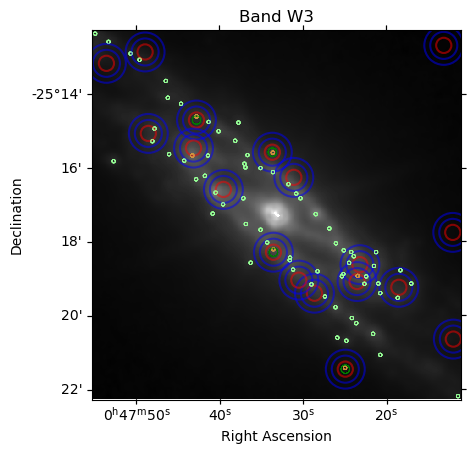

Band W4: 
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/01/0116/0116m258_ac51/0116m258_ac51-w4-int-3.fits


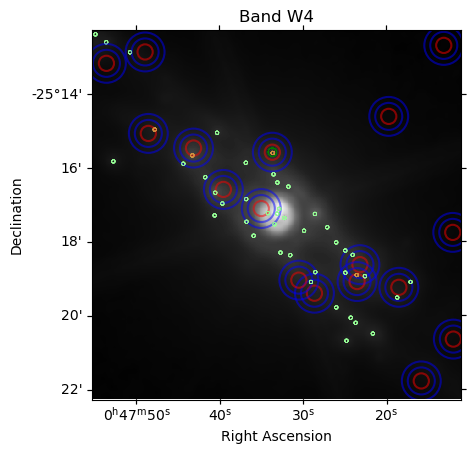

Band W2: 
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/01/0116/0116m258_ac51/0116m258_ac51-w2-int-3.fits


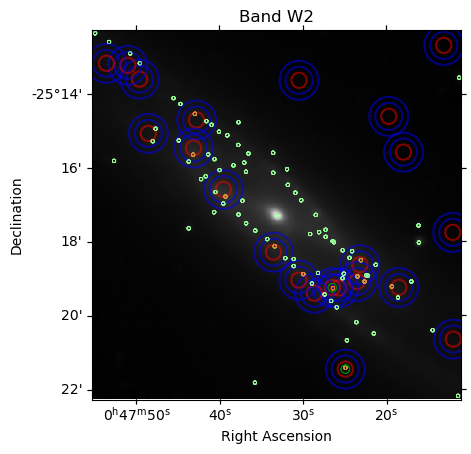

Band W1: 
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/01/0116/0116m258_ac51/0116m258_ac51-w1-int-3.fits


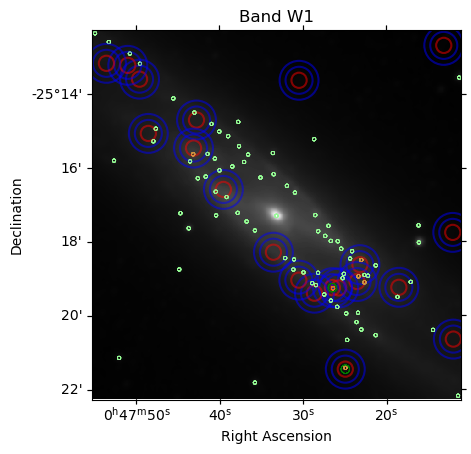

NGC 0891
<DALResultsTable length=4>
      sia_title        ...    coadd_id  
                       ...              
        object         ...     object   
---------------------- ... -------------
W1 Coadd 0364p424_ac51 ... 0364p424_ac51
W3 Coadd 0364p424_ac51 ... 0364p424_ac51
W4 Coadd 0364p424_ac51 ... 0364p424_ac51
W2 Coadd 0364p424_ac51 ... 0364p424_ac51
Galaxy: NGC 0891
RA values: [35.34721086 35.3692117  35.38187132 35.42100804 35.42599685 35.42790758
 35.4280745  35.43339575 35.43551712 35.44311396 35.46608447 35.48291519
 35.51147764 35.51729905 35.52161919 35.52161822 35.52485472 35.52937934
 35.54254426 35.5453959  35.54912412 35.54931761 35.56297292 35.56331047
 35.56492698 35.56509245 35.58074066 35.59036948 35.60178802 35.60547529
 35.60746877 35.60967833 35.61093696 35.61220798 35.61332966 35.61336365
 35.61353575 35.61373366 35.61419071 35.6152066  35.621001   35.62349901
 35.62634652 35.63026186 35.63048065 35.63088014 35.63307997 35.63321017
 35.63401866 35.6345148 

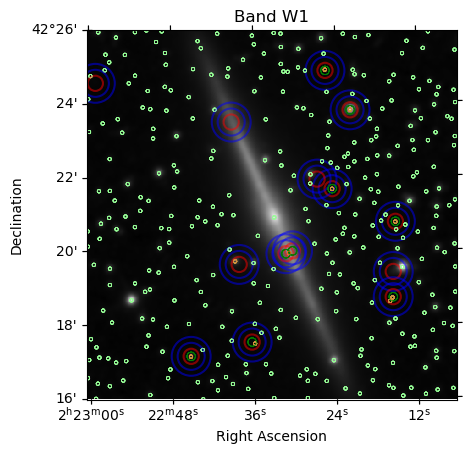

Band W2: 
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/03/0364/0364p424_ac51/0364p424_ac51-w2-int-3.fits


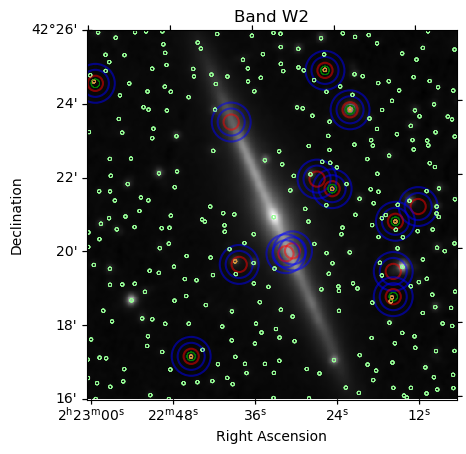

Band W4: 
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/03/0364/0364p424_ac51/0364p424_ac51-w4-int-3.fits


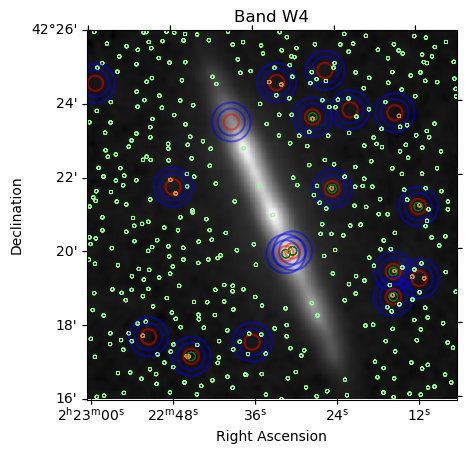

Band W3: 
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/03/0364/0364p424_ac51/0364p424_ac51-w3-int-3.fits


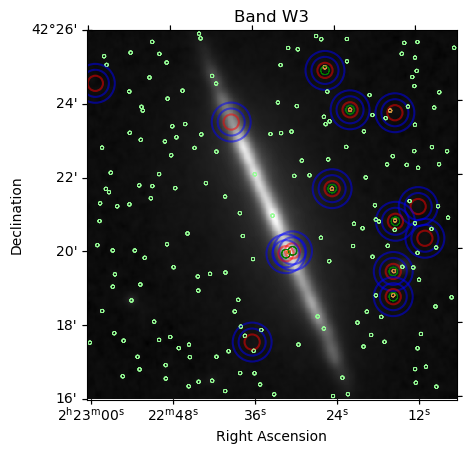

NGC 1291:[LFF2012] 084
<DALResultsTable length=4>
      sia_title        ...    coadd_id  
                       ...              
        object         ...     object   
---------------------- ... -------------
W1 Coadd 0494m409_ac51 ... 0494m409_ac51
W4 Coadd 0494m409_ac51 ... 0494m409_ac51
W2 Coadd 0494m409_ac51 ... 0494m409_ac51
W3 Coadd 0494m409_ac51 ... 0494m409_ac51
Galaxy: NGC 1291:[LFF2012] 084
RA values: [49.00472987 49.03838997 49.04581933 49.06534973 49.06799976 49.07444148
 49.07736525 49.08881456 49.09159152 49.09248699 49.09648862 49.09899005
 49.10453585 49.10522585 49.13262663 49.13601004 49.15892381 49.16583724
 49.17034748 49.17149642 49.19617535 49.19841988 49.20052298 49.20081162
 49.20305614 49.20322858 49.20785114 49.21040214 49.21438009 49.21942389
 49.22163339 49.22532734 49.23120907 49.23358222 49.23807216 49.24453681
 49.244746   49.24877589 49.25114006 49.25335434 49.25478252 49.26067934
 49.26134219 49.26655559 49.27008466 49.27459376 49.27513427 49.27677

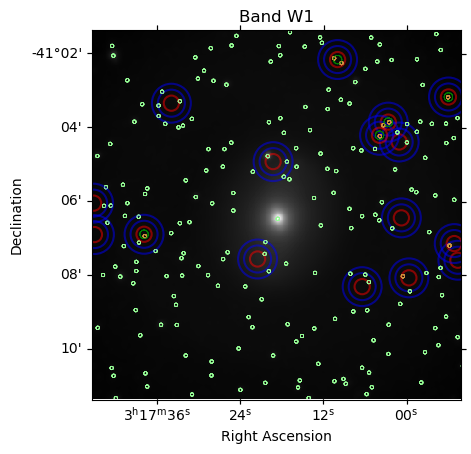

Band W3: 
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/04/0494/0494m409_ac51/0494m409_ac51-w3-int-3.fits


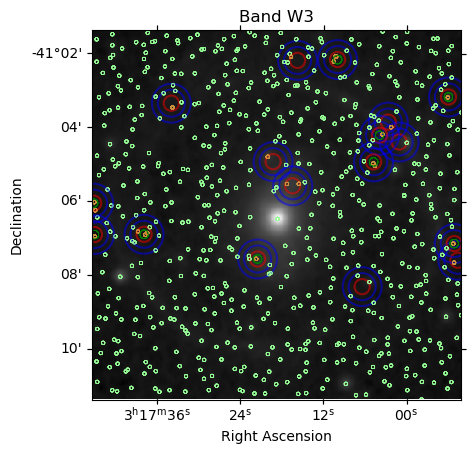

Band W2: 
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/04/0494/0494m409_ac51/0494m409_ac51-w2-int-3.fits


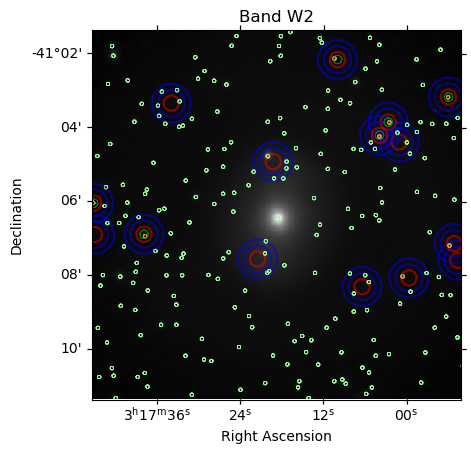

Band W4: 
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/04/0494/0494m409_ac51/0494m409_ac51-w4-int-3.fits


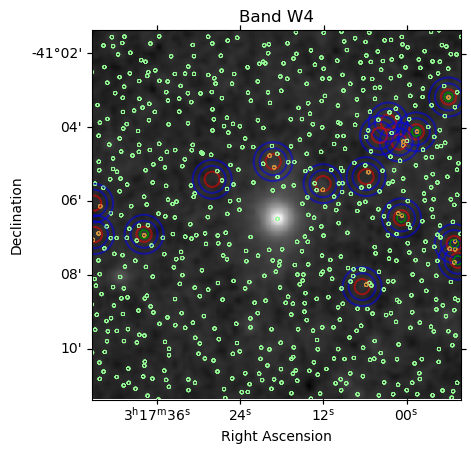

NGC 4631
<DALResultsTable length=8>
      sia_title        ...    coadd_id  
                       ...              
        object         ...     object   
---------------------- ... -------------
W4 Coadd 1905p318_ac51 ... 1905p318_ac51
W1 Coadd 1907p333_ac51 ... 1907p333_ac51
W3 Coadd 1907p333_ac51 ... 1907p333_ac51
W2 Coadd 1907p333_ac51 ... 1907p333_ac51
W4 Coadd 1907p333_ac51 ... 1907p333_ac51
W3 Coadd 1905p318_ac51 ... 1905p318_ac51
W2 Coadd 1905p318_ac51 ... 1905p318_ac51
W1 Coadd 1905p318_ac51 ... 1905p318_ac51
Galaxy: NGC 4631
RA values: [190.26164276 190.27018824 190.27662993 190.32047503 190.35997614
 190.36118161 190.36617596 190.36819186 190.36903799 190.37457163
 190.37593438 190.39139499 190.39813092 190.39918758 190.40347212
 190.40542166 190.40895441 190.41779959 190.41892824 190.41965362
 190.43674121 190.4472906  190.4551523  190.45760227 190.46148554
 190.46572373 190.46717887 190.46816266 190.47579271 190.48152605
 190.48324513 190.48384446 190.48921188 190.4904

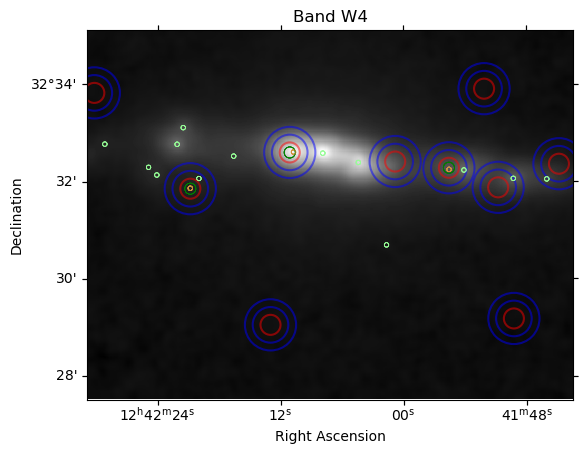

Band W2: 
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/19/1907/1907p333_ac51/1907p333_ac51-w2-int-3.fits


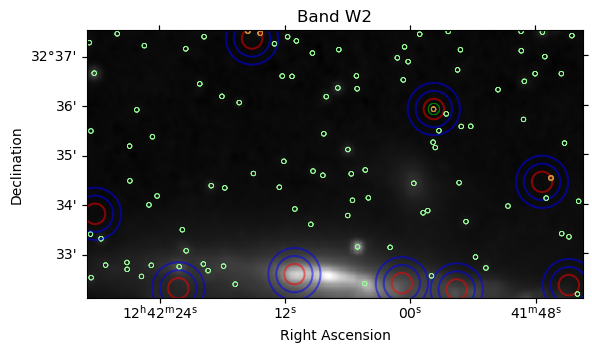

Band W3: 
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/19/1907/1907p333_ac51/1907p333_ac51-w3-int-3.fits


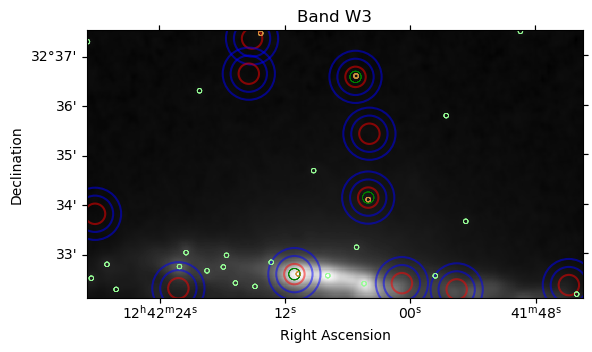

Band W1: 
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/19/1907/1907p333_ac51/1907p333_ac51-w1-int-3.fits


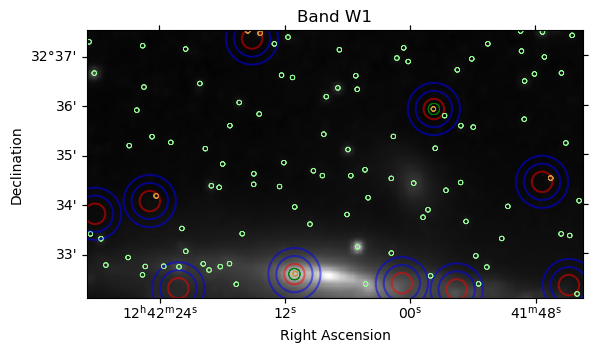

MESSIER 094
<DALResultsTable length=4>
      sia_title        ...    coadd_id  
                       ...              
        object         ...     object   
---------------------- ... -------------
W3 Coadd 1918p408_ac51 ... 1918p408_ac51
W1 Coadd 1918p408_ac51 ... 1918p408_ac51
W2 Coadd 1918p408_ac51 ... 1918p408_ac51
W4 Coadd 1918p408_ac51 ... 1918p408_ac51
Galaxy: MESSIER 094
RA values: [192.39289799 192.5689889  192.5862114  192.59593371 192.60126422
 192.61738391 192.61910651 192.63418729 192.63777626 192.64573043
 192.64668224 192.64967687 192.65716262 192.67413097 192.67615822
 192.67857837 192.68389781 192.69832487 192.69991305 192.6999489
 192.70252203 192.70377693 192.70808877 192.70967218 192.70970365
 192.71137016 192.71281879 192.71599881 192.71705324 192.71770045
 192.71798921 192.71833005 192.71883785 192.71902278 192.71963756
 192.71965751 192.71987376 192.72080908 192.72090713 192.72110178
 192.72144057 192.72154701 192.72202774 192.7221332  192.72214437
 192.7222

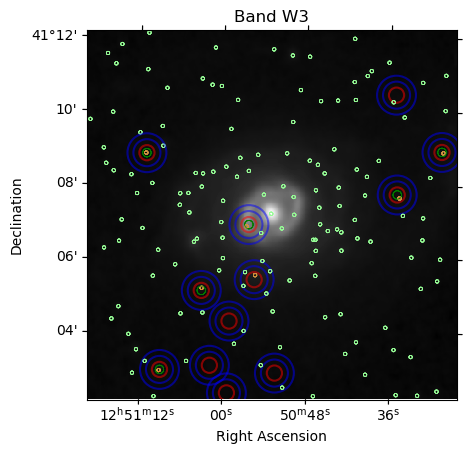

Band W4: 
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/19/1918/1918p408_ac51/1918p408_ac51-w4-int-3.fits


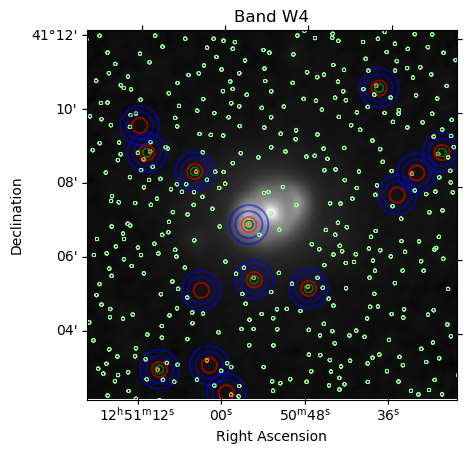

Band W2: 
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/19/1918/1918p408_ac51/1918p408_ac51-w2-int-3.fits


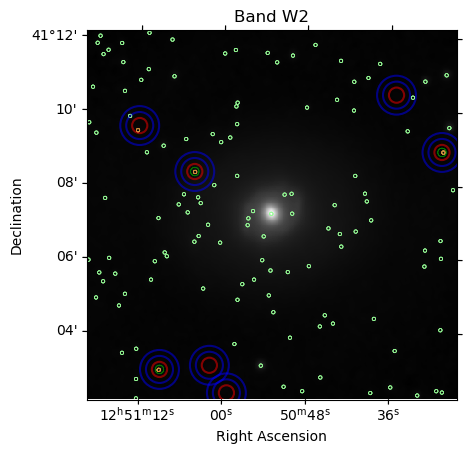

Band W1: 
https://irsa.ipac.caltech.edu/ibe/data/wise/allwise/p3am_cdd/19/1918/1918p408_ac51/1918p408_ac51-w1-int-3.fits


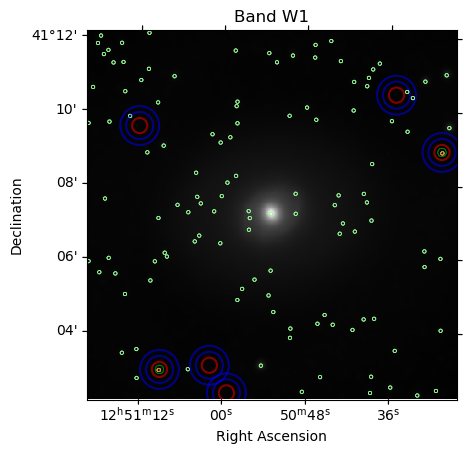

Number of valid sources:  627
Number of sources that dont 100 percent overlap x4 (because it is iterating over all 4 bands and appending each one once):  1888
Number of sources coincidental with WISE bright points within 5 arcsec:  241

 all of the valid sources


band_id             Galaxy Name  ObsID  Region           X           Y  \
6       {W3}             MESSIER 094   9553       7  419.248272  291.589610   
9       {W3}             MESSIER 094   9553      10  366.311412  241.325230   
10      {W3}             MESSIER 094   9553      11  365.488411  359.333423   
17      {W3}                NGC 0253  20343      18  426.908528   70.919963   
18      {W3}                NGC 0253  20343      19  426.215688  197.083030   
19      {W3}                NGC 0891    794      20  399.038653  190.127043   
20      {W3}                NGC 4631    797      21  424.061185   10.455812   
21      {W3}                NGC 0891    794      22  391.071704  227.638952   
22      {W3}                NGC 0891    794      23  363.552379  338.550916   
23      {W3}                NGC 0891    794      24  364.169991  210.200808   
24      {W3}                NGC 0891    794      25  361.627119  150.921226   
25      {W3}                NGC 0891    794      26  361.601367  121.065705   
26      {W3}                NGC 0253  20343      27  362.478864  132.144127   
27      {W3}                NGC 0891    794      28  310.546421  342.023340   
28      {W3}                NGC 0891    794      29  289.349469  248.767542   
29      {W3}             MESSIER 094   9553      30  221.088687   30.748310   
30      {W3}  NGC 1291:[LFF2012] 084  11272      31  427.964560  183.876302   
31      {W3}  NGC 1291:[LFF2012] 084  11272      32  421.126789  357.179071   
37      {W3}                NGC 0253  20343      38  316.454252  158.927065   
38      {W3}                NGC 4631    797      39  276.954331   12.137832   
39      {W3}                NGC 0253  20343      40  313.089658  138.956147   
40      {W3}  NGC 1291:[LFF2012] 084  11272      41  362.851474  303.955179   
42      {W3}  NGC 1291:[LFF2012] 084  11272      43  349.955287  327.479801   
43      {W3}                NGC 4631    797      44  248.325967  143.779688   
44      {W3}                NGC 4631    797      45  247.272388   87.510962   
47      {W3}                NGC 4631    797      48  236.087763  193.884531   
48      {W3}             MESSIER 094   9553      49  197.138285  141.188775   
50      {W3}             MESSIER 094   9553      51  190.928632  206.315665   
51      {W3}  NGC 1291:[LFF2012] 084  11272      52  290.023312  401.440830   
52      {W3}             MESSIER 094   9553      53  167.424115   92.251406   
53      {W3}             MESSIER 094   9553      54  164.352083    7.327992   
56      {W3}             MESSIER 094   9553      57  144.214623   39.963182   
58      {W3}             MESSIER 094   9553      59  134.640093  128.492152   
60      {W3}                NGC 0253  20343      61  262.679763  125.170212   
61      {W3}                NGC 4631    797      62  182.228974   20.095048   
62      {W3}  NGC 1291:[LFF2012] 084  11272      63  236.966363  252.155815   
63      {W3}                NGC 0891    794      64  194.782103   67.414589   
64      {W3}             MESSIER 094   9553      65   85.215085   35.066199   
65      {W3}             MESSIER 094   9553      66   70.381436  291.313294   
66      {W3}                NGC 4631    797      67  142.070134  196.678804   
69      {W3}                NGC 0253  20343      70  244.215569  140.631714   
71      {W3}  NGC 1291:[LFF2012] 084  11272      72  213.813524  280.761211   
72      {W3}                NGC 4631    797      73   80.014800    7.641951   
74      {W3}  NGC 1291:[LFF2012] 084  11272      75  195.422722  165.621982   
75      {W3}                NGC 4631    797      76    6.580300   73.240605   
76      {W3}                NGC 0253  20343      77  238.274340  262.133563   
78      {W3}                NGC 0891    794      79    9.394717  373.325797   
89      {W3}  NGC 1291:[LFF2012] 084  11272      90   93.507913  349.838355   
91      {W3}  NGC 1291:[LFF2012] 084  11272      92   61.201405  194.859618   
92      {W3}  NGC 1291:[LFF2012] 084  11272      93    


 all of the Yes!! sources


band_id             Galaxy Name  ObsID  Region           X           Y  \
6       {W3}             MESSIER 094   9553       7  419.248272  291.589610   
9       {W3}             MESSIER 094   9553      10  366.311412  241.325230   
23      {W3}                NGC 0891    794      24  364.169991  210.200808   
24      {W3}                NGC 0891    794      25  361.627119  150.921226   
25      {W3}                NGC 0891    794      26  361.601367  121.065705   
27      {W3}                NGC 0891    794      28  310.546421  342.023340   
28      {W3}                NGC 0891    794      29  289.349469  248.767542   
30      {W3}  NGC 1291:[LFF2012] 084  11272      31  427.964560  183.876302   
31      {W3}  NGC 1291:[LFF2012] 084  11272      32  421.126789  357.179071   
44      {W3}                NGC 4631    797      45  247.272388   87.510962   
47      {W3}                NGC 4631    797      48  236.087763  193.884531   
50      {W3}             MESSIER 094   9553      51  190.928632  206.315665   
51      {W3}  NGC 1291:[LFF2012] 084  11272      52  290.023312  401.440830   
58      {W3}             MESSIER 094   9553      59  134.640093  128.492152   
61      {W3}                NGC 4631    797      62  182.228974   20.095048   
64      {W3}             MESSIER 094   9553      65   85.215085   35.066199   
65      {W3}             MESSIER 094   9553      66   70.381436  291.313294   
74      {W3}  NGC 1291:[LFF2012] 084  11272      75  195.422722  165.621982   
91      {W3}  NGC 1291:[LFF2012] 084  11272      92   61.201405  194.859618   
92      {W3}  NGC 1291:[LFF2012] 084  11272      93    2.564722  194.500477   
93      {W3}  NGC 1291:[LFF2012] 084  11272      94    1.553235  231.666749   
95      {W3}                NGC 0253  20343      96  214.191692  173.656954   
96      {W3}                NGC 0253  20343      97  212.881334  291.907899   
111     {W3}                NGC 0253  20343     112  123.210481  329.949902   
144     {W4}             MESSIER 094   9553       7  419.248272  291.589610   
150     {W4}             MESSIER 094   9553      13  344.910979  367.760758   
154     {W4}             MESSIER 094   9553      17  261.540456  130.849391   
159     {W4}                NGC 0891    794      22  391.071704  227.638952   
163     {W4}                NGC 0891    794      26  361.601367  121.065705   
166     {W4}                NGC 0891    794      29  289.349469  248.767542   
167     {W4}                NGC 4631    797      30  324.595715  207.647610   
168     {W4}  NGC 1291:[LFF2012] 084  11272      31  427.964560  183.876302   
169     {W4}  NGC 1291:[LFF2012] 084  11272      32  421.126789  357.179071   
172     {W4}                NGC 0891    794      35  266.231736  333.541595   
173     {W4}  NGC 1291:[LFF2012] 084  11272      36  383.102571  315.977549   
177     {W4}  NGC 1291:[LFF2012] 084  11272      40  365.467236  214.263298   
186     {W4}             MESSIER 094   9553      49  197.138285  141.188775   
188     {W4}             MESSIER 094   9553      51  190.928632  206.315665   
199     {W4}                NGC 4631    797      62  181.625392  221.413736   
200     {W4}             MESSIER 094   9553      63  126.933973  269.066750   
202     {W4}             MESSIER 094   9553      65   85.215085   35.066199   
203     {W4}             MESSIER 094   9553      66   70.381436  291.313294   
209     {W4}                NGC 4631    797      72   92.309356  188.850448   
211     {W4}                NGC 0891    794      74  122.683152   50.532096   
229     {W4}  NGC 1291:[LFF2012] 084  11272      92   61.201405  194.859618   
234     {W4}                NGC 0253  20343      97  212.881334  291.907899   
282     {W2}             MESSIER 094   9553       7  419.248272  291.589610   
299     {W2}                NGC 0891    794      24  364.169991  210.200808   
301     {W2}                NGC 0891    794      26  361.601367  121.065705   
303     {W2}                NGC 0891    794      28  31

627


'\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n#define coordinates\nra= 359.45700000000016\ndec= -32.592000000000013\npos = SkyCoord(ra=ra, dec=dec, unit= \'deg\')\n#print(pos)\n\n\n# Lookup and define a service for ALLWISE Atlas images\n# the website gave me the URL\nallwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")\n\n\n#search the service for images covering within 1 arcsecond of the star. make this bigger if needed\nim_table = allwise_service.search(pos=pos, size= 1*u.arcsec)\n#im_table\nim_table.to_table().colnames\n#for i in range(len(im_table)):\n   #print(im_table[i])\n\n\n\n\n#group the x-ray sources for this galaxy. locate through merging\ndf1 = targetgals\ndf2 = g_huge\n\n\nmerged_data = pd.merge(df1, df2, left_on=\'source_id\', right_on = \'Gname_Homogenized\', how=\'inner\')\ncolumns = [\'RA\',\'Dec\',\'Gname_Homogenized\']\nXray_sources = merged_data[columns]\nGalaxies = Xray_sources.groupby([\'Gname_Homogenized\'])\n\

In [20]:
####Defining the constants
# defining a function to calculate the distances between two sources.
def dist(p1, p2):
   return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )


#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
   Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
   dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
   mask = dist_from_center <= radius # so that everything inside the radius receives a mask
   return mask


# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6 ,'w4':12.98 }
wavelengths = {'w1': 3.4 ,'w2': 4.6,'w3': 12,'w4': 22}


#define function to get flux density per unit frequency (energy units)
def flux_dens(net_flx, net_flx_err, wavelength):
   flux_density = (net_flx * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   flux_density_unc = (net_flx_err * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   return flux_density, flux_density_unc


'''
make a conditional code where:
choose one obs id and eerything associated with it bwith the longest exposuretime exptime?
tell me all of the obsids associated with this galaxy_name
    unique list of each galaxy Name
    what are the obs ids associated with it
    if more than one which one is the longest exposure
    aggregate all of the associated sources with it and none from any of the others


'''


#import huge csv and grab the name and ra and dec needed for each galaxy.
targetgals = pd.read_csv('../Data/inWISE.csv') # this should not be the one for all 120 and should rather be for the 74 of them.
#print(targetgals[0:20])
huge = pd.read_csv('../Data/Hugefiles/Source_Flux_All_Modified_5.csv')
columns = ['RA','Dec','Gname_Modified','Gname_Homogenized', 'ObsID', 'EXPOSURE']
g_huge = huge[columns]
#display(g_huge.head())


#group the x-ray sources for this galaxy. locate through merging
df1 = targetgals
df2 = g_huge




merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns1 = ['RA','Dec','Gname_Homogenized', 'ObsID', 'EXPOSURE']
Xray_sources = merged_data[columns1]


#group by galaxy name and the longest exposure time.
longest_exposure_obs = Xray_sources.loc[Xray_sources.groupby('Gname_Homogenized')['EXPOSURE'].idxmax()]


# aggregate all the sources associated with the obsid with the longest exposure time
aggregated_sources = Xray_sources[Xray_sources['ObsID'].isin(longest_exposure_obs['ObsID'])]




#align them based on source Id since they all got jumbled.
#aligned_targetgals = targetgals[targetgals.isin(aggregated_sources['Gname_Homogenized'])]


#reset index and group them by name
#aligned_targetgals = aligned_targetgals.reset_index(drop=True)
#print(aligned_targetgals)
#aligned_aggregatedsources = aggregated_sources.groupby('Gname_Homogenized')






'''
print("Unique list of each galaxy name:")
print(targetgals['source_id'])


print("\nObservations with the longest exposure time for each galaxy:")
print(longest_exposure_obs)


print("\nAggregated sources:")
print(aggregated_sources)
#'''












# Ensure the uniqueness for NGC 5128
#ngc_5128_sources = Xray_sources[Xray_sources['Gname_Homogenized'] == 'NGC 5128']
#print(f"Number of unique X-ray sources for NGC 5128: {len(ngc_5128_sources)}")
#print(ngc_5128_sources)


pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
#display(g_huge)
#display(Xray_sources)








#create a list of all the names needed
galaxy_names = targetgals['source_id'].unique()




galaxy_sources = {}
grouped_sources = aggregated_sources.groupby('Gname_Homogenized')
'''print("\nGrouped sources:")
for group_name, group in grouped_sources:
   print(f"\nGroup: {group_name}")
   print(group)'''
#get all of the ra and dec sources for the galaxy in question
for group_name, group in grouped_sources:
   galaxy_sources[group_name] = {'ra' : group['RA'].values, 'dec' : group['Dec'].values, 'ObsID': group['ObsID'].values}
  






#### initialize everything

#overlap_percent = []
#distance = []
























rows = []
#create subsets for testing:
#grouped_sources_subset = grouped_sources.head(2)
#targetgals_subset = targetgals.head(2)


targetgals_subset = targetgals.iloc[5:10]


# Lookup and define a service for ALLWISE Atlas images
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")
#loop through the galaxies
print("\nAligned target galaxies and grouped sources:")


for galaxy in targetgals_subset.itertuples():
   galaxy_name = galaxy.source_id
   print(galaxy_name)
   #group = aligned_aggregatedsources.get_group(galaxy_name)
  
   # Print galaxy information
   #print(f"\nGalaxy: {galaxy_name}")
   #print(group)


   #define coordinates
   ra1 = galaxy.ra_x
  #print (ra1)
   dec1 = galaxy.dec_x
   pos = SkyCoord(ra=ra1, dec=dec1, unit= 'deg')
   #search the service for images covering within 1 arcsecond of the star. make this bigger if needed
   im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
   #im_table
   im_table.to_table().colnames
   print(im_table)
   # get the Ra and dec values necessary for the kdtree and rest of the code
  
   if galaxy_name in galaxy_sources:
       ra = galaxy_sources[galaxy_name]['ra']
       dec = galaxy_sources[galaxy_name]['dec']
       obsid = galaxy_sources[galaxy_name]['ObsID']
       print(f"Galaxy: {galaxy_name}")
       print("RA values:", ra)
       print("Number of RA values:", len(ra))
   else:
       print(f"No sources found for galaxy: {galaxy_name}")
          
   ##running the for loop over every image and doing aperture photometry on each one
   #currently outputs as w4,w1,w2,w3 when querying the images. so index is 0.1.2.3 i want the index to be 0.3.2.1


   for i in [0, 3, 2, 1]:  # Reverse order index
       band_id = im_table[i]["sia_bp_id"].lower()  # Get band ID in lowercase


       if band_id in band_labels:
           print(f'Band {band_labels[band_id]}: ')
           data_url = im_table[i].getdataurl()
           #Download the image and open it in Astropy
           fname = download_file(data_url, cache=True)
           image1= fits.open(fname)
           image_data= image1[0].data
           #print(data)
           print(data_url)
           wcs = WCS(image1[0].header)
           #cuting out the image of the galaxy apart from the rest of the background.
           cutout = Cutout2D(image_data, pos, (437,437), wcs=wcs)
           wcs = cutout.wcs
           cutout_data = cutout.data
           #print(cutout_data)
           positions = wcs.world_to_pixel_values(ra, dec)
           positions = np.array(list(zip(positions[0], positions[1])))


           #define the distance threshold for the KDTree grouping (in pixels)
           distance_threshold = 6


           #build the KDTree for efficient grouping
           tree = KDTree(positions)


           #query the KDTree to find points within the defined radius of dist threshold and group them together
           groups = tree.query_ball_tree(tree, r=distance_threshold)
       # print(groups)
           # consolidating the groups. 'unique_groups' and 'seen': These are used to ensure that each group is processed only once.
           unique_groups = []
           seen = set()
           for group in groups:
               group = tuple(sorted(group))
               if group not in seen:
                   seen.add(group)
                   unique_groups.append(group)
       # print(unique_groups)
           # for each unique group, the average postion of the detections is calulated so that only one source detection is used for aperture photometry instead of a bunch of the same sources being used.
           #represents the consolidated postion of potentially multiple detections of one source.
           grouped_positions = [positions[list(group)].mean(axis=0) for group in unique_groups]
           #print(grouped_positions)


           #define the Region(s) Of Interest (center x, center y, radius)
           ROI = [ ((x, y) , 9, 16, 23) for x,y in grouped_positions ] # (x, y, radius around target, inner r, outer r)   36.3636, 50.90909) may need to mke the radius bigger when goruping?
          


           # initialize valid rows plotting for the current image iteration
           valid_rows = []
          
           #now inputting the aperture photometry part
           # check for overlap and perform aperture photometry
           for i, ((x, y), r, annulus_inner, annulus_outer) in  enumerate(ROI):
               overlap = False # initialize overlap flag (A boolean flag overlap is set to False for each source to track if it overlaps with any other source. becomes true if they do overlap 
               acc_overlap = False # initialize the acceptable overlap flag.  false if there is no overlap, true if there is overlap and it is acceptable 

               for j, ((x2, y2), r2, annulus_inner2, annulus_outer2) in  enumerate(ROI): # apparently you can run a for loop over 2 objects by putting the second one inside the first. it iterates over every source again to then see if it overlaps at all with another source.
                   if i != j: # ensures that a source is not compared to itself! wow
                       distance = dist((x, y) , (x2, y2))
                       #print('dsitance', distance)
                       if distance < r + r2:  # if the distance is less than the size of the two radii added together, then they are overlapping.
                           overlap_percent = (r + r2 - distance)/(r+r2)  # the amount they are overlapping divided by the total size of radii distance
                           #print('overlap perc', overlap_percent)
                           if overlap_percent > .5:
                               overlap = True # this way, if they overlap by more than 50% then they will not be usable because less than 50% of the flux extractable area can be seen.
                               #print('overlap is unacceptable: ', overlap)
                               overlap_aperture = np.nan
                               overlap_photo_table = np.nan
                               overlap_counts = np.nan
                               overlap_error = np.nan
                              
                           elif overlap_percent < .5:
                                acc_overlap = True
                                #print('acceptable or no overlap: ', acc_overlap)
                                #Handle overlaps that are acceptable (less than the threshold, but still overlapping by a small percent)
                                overlap_aperture = CircularAperture((x2, y2), r2)
                                overlap_photo_table = aperture_photometry(cutout_data, overlap_aperture)
                                overlap_counts = overlap_photo_table['aperture_sum'][0]
                                overlap_error = np.sqrt(overlap_counts)


                       else:
                           #print('not overlapping at all')
                           overlap_percent = np.nan
                           overlap_aperture = np.nan
                           overlap_photo_table = np.nan
                           overlap_counts = np.nan
                           overlap_error = np.nan
                   
                       
                           
               if acc_overlap:
                   # For the Target objects in the little aperture circle define their target apertures
                   target_aperture = CircularAperture((x,y),r,)
              
                   #perform aperture photometry on target
                   target_photo_table = aperture_photometry(cutout_data, target_aperture)
                   target_counts = target_photo_table['aperture_sum'][0]
                   target_counts -= overlap_counts


                   # so that i dont take the log or sqrt of a negative number or zero and get an error
                   if target_counts > 0: #
                       target_error= np.sqrt(target_counts)
                       #propagated error of overlap error
                       target_overlap_counts_err = np.sqrt(target_error**2 + overlap_error**2)
                       #print(target_counts)
                       if band_id in flux_zmfd and instr_zpmag:
                           #print(f'Band {flux_zmfd[band_id]}: ')
                           flx_conv_fact = flux_zmfd[band_id]
                           M0instr = instr_zpmag[band_id]
                           Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                           target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux
                          
                           #propagation of uncertainty of flux conversion
                           Mcal_error = (2.5*target_overlap_counts_err) / (target_counts * np.log(10))
                           target_flux_error = target_flux * np.log(10) * (Mcal_error/2.5)


                   else:
                           # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        target_error = np.nan
                        target_overlap_counts_err = np.nan
                        target_flux = np.nan
                        target_flux_error = np.nan
                        flx_conv_fact = np.nan
                        M0instr = np.nan
                        target_counts = np.nan

                   # continuing on with the photometry under the "if acc_overlap"


                   #calculate area of target aperutue
                   target_area = target_aperture.area

                   # For the Background Annuli of outside of the Target
                   #define the background annulus for the target
                   annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)


                   #perform aperture photometry on annuli
                   annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                   annulus_counts = annulus_photo_table['aperture_sum'][0]
                  
              
                   if annulus_counts > 0:
                       overlapannulus_error = np.sqrt(annulus_counts) # the error of the annulus for sources that overlap
                       # to avoid taking the log of zero or negative value
                       if band_id in flux_zmfd and instr_zpmag:
                           #print(f'Band {flux_zmfd[band_id]}: ')
                           flx_conv_fact = flux_zmfd[band_id]
                           M0instr = instr_zpmag[band_id]
                           Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                           annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux


                           #propagation of uncertainty of flux conversion
                           Mcal_error_ann = (2.5 * overlapannulus_error) / (annulus_counts * np.log(10))
                           annulus_flux_error = annulus_flux * np.log(10) * (Mcal_error_ann/2.5)




                   else: 
                        annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                        overlapannulus_error = np.nan
                        flx_conv_fact = np.nan
                        M0instr = np.nan
                        annulus_counts = np.nan
                          
                   #calculate area of annulus
                   annulus_area = annulus_aperture.area


                   # do the calculations for including a Background aperture
              
                   #Calculating the net flux:
                   #calculate the mean background per pixel
                   bg_perpixel = annulus_flux/annulus_area
                   bg_perpixel_err = annulus_flux_error/annulus_area #propagation of error!


                   #calculate the total background in the target aperture
                   tot_bg = bg_perpixel * target_area
                   tot_bg_err = bg_perpixel_err * target_area ##propagation of error!


                   #Subtract background from the target flux
                   net_flx = target_flux - tot_bg
                   net_flx_err = np.sqrt(target_flux_error**2 + tot_bg_err**2) ##propagation of error!
              
                   #flag the sources that overlap
                   rows.append({ 'band_id': {band_labels[band_id]}, 'Galaxy Name' : galaxy_name, 'ObsID' : obsid[0], 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                           'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx,'Flux Uncertainty': net_flx_err, 'Flag':'Valid' if not np.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux',
                           'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                               'Annulus Counts': annulus_counts, 'Overlap Counts': overlap_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                               'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error, 'Wavelength': wavelengths[band_id], 'Flux Density': [], 'Flux Density Uncertainty' : [] })
                   # Append valid results to valid_rows
                   valid_rows.append({
                       'band_id': {band_labels[band_id]},  'Galaxy Name' : galaxy_name, 'ObsID' : obsid[0],
                       'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                       'Annulus_Inner_Radius': annulus_inner,
                       'Annulus_Outer_Radius': annulus_outer,
                       'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,'Flag':'Valid' if not np.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux', 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                       'Offset in Arcseconds': [], 'Exists?': 'No', 'Point Source Position' : [],  'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': overlap_error, 'Wavelength': wavelengths[band_id], 'Flux Density': [], 'Flux Density Uncertainty' : [] })
                  
               else: #perform all the normal aperture photometry stuff for those that do not overlap in any way.
                   # For the Target objects in the little aperture circle define their target apertures
                   target_aperture = CircularAperture((x,y),r,)
              
                   #perform aperture photometry on target
                   target_photo_table = aperture_photometry(cutout_data, target_aperture)
                   target_counts = target_photo_table['aperture_sum'][0]


                   if target_counts > 0: #
                       # avoid taking the log of zero or negative value
                       target_error = np.sqrt(target_counts)
                       if band_id in flux_zmfd and instr_zpmag:
                           #print(f'Band {flux_zmfd[band_id]}: ')
                           flx_conv_fact = flux_zmfd[band_id]
                           M0instr = instr_zpmag[band_id]
                           Mcal_trgt = M0instr - 2.5*(np.log10(target_counts))     #converting counts to magnitude
                           target_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux


                           #propagation of uncertainty of flux conversion
                           Mcal_error = (2.5*target_error) / (target_counts * np.log(10))
                           target_flux_error = target_flux * np.log(10) * (Mcal_error/2.5)


                   else:
                        target_error = np.nan
                        target_flux = np.nan
                        target_flux_error = np.nan
                        flx_conv_fact = np.nan
                        M0instr = np.nan
                        target_counts = np.nan

                      
                   #calculate area of target aperutue
                   target_area = target_aperture.area




                   # For the Background Annuli of outside of the Target
                   #define the background annulus for the target
                   annulus_aperture = CircularAnnulus((x, y), annulus_inner, annulus_outer)


                   #perform aperture photometry on annuli
                   annulus_photo_table = aperture_photometry(cutout_data, annulus_aperture)
                   annulus_counts = annulus_photo_table['aperture_sum'][0]
                   # the error of the annulus for sources that overlap
                  
                   if annulus_counts > 0:
                       annulus_error = np.sqrt(annulus_counts)
                       # avoid taking the log of zero or negative value
                       if band_id in flux_zmfd and instr_zpmag:
                           #print(f'Band {flux_zmfd[band_id]}: ')
                           flx_conv_fact = flux_zmfd[band_id]
                           M0instr = instr_zpmag[band_id]
                           Mcal_trgt = M0instr - 2.5*(np.log10(annulus_counts))     #converting counts to magnitude
                           annulus_flux = flx_conv_fact * 10**(Mcal_trgt/-2.5)      #convert Magnitude to Flux


                           #propagation of uncertainty of flux conversion
                           Mcal_error_ann = (2.5 * annulus_error) / (annulus_counts * np.log(10))
                           annulus_flux_error = annulus_flux * np.log(10) * (Mcal_error_ann/2.5)
                   else:
                           annulus_flux = np.nan # to handle the cases where the counts are not more than 0 and if the conversion factors are missing.
                           annulus_error = np.nan
                           annulus_flux_error = np.nan
                           flx_conv_fact = np.nan
                           M0instr = np.nan
                           annulus_counts = np.nan
                          
                   #calculate area of annulus
                   annulus_area = annulus_aperture.area


                   # do the calculations for including a Background aperture
              
                   #Calculating the net flux:
                   #calculate the mean background per pixel
                   bg_perpixel = annulus_flux/annulus_area
                   bg_perpixel_err = annulus_flux_error/annulus_area #propagation of error!


                   #calculate the total background in the target aperture
                   tot_bg = bg_perpixel * target_area
                   tot_bg_err = bg_perpixel_err * target_area ##propagation of error!


                   #Subtract background from the target flux
                   net_flx = target_flux - tot_bg
                   net_flx_err = np.sqrt(target_flux_error**2 + tot_bg_err**2) ##propagation of error!


                   #   Append the result as a dictionary to the list named 'rows'
                   rows.append({ 'band_id': {band_labels[band_id]}, 'Galaxy Name' : galaxy_name, 'ObsID' : obsid[0], 'Region': i+1, 'X': x, 'Y': y, 'Radius': r, 'Annulus_Inner_Radius': annulus_inner,
                           'Annulus_Outer_Radius': annulus_outer, 'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,  'Flag':'Valid' if not np.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux',
                           'aperture_sum': target_photo_table['aperture_sum'][0] ,'tot_bg': tot_bg, 'Target Counts': target_counts, 'Target Flux': target_flux,
                               'Annulus Counts': annulus_counts, 'Annulus Flux': annulus_flux,'Image Data Shape': cutout_data.shape, 'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr,
                               'Offset in Arcseconds': [],   'Exists?': 'No', 'Point Source Position' : [], 'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': [], 'Wavelength': wavelengths[band_id],'Flux Density': [], 'Flux Density Uncertainty' : [] })  #will prolly have to change the name of the Flux here!!!
               #"Low Flux" means that they either have zero flux or negative flux and so they are excluded from the plotting
              
                   # Append valid results to valid_rows
                   valid_rows.append({
                       'band_id': {band_labels[band_id]}, 'Galaxy Name' : galaxy_name, 'ObsID' : obsid[0],
                       'Region': i+1, 'X': x, 'Y': y, 'Radius': r,
                       'Annulus_Inner_Radius': annulus_inner,
                       'Annulus_Outer_Radius': annulus_outer,
                       'Net Flux (Jy)': net_flx, 'Flux Uncertainty': net_flx_err,
                       'Flag':'Valid' if not np.isnan(target_counts) and target_counts > 0 and net_flx > 0 else 'Low Flux',
                       'Flux Conv':flx_conv_fact, 'MzpInstr':M0instr, 'Exists?': 'No', 'Point Source Position' : [], 'Offset in Arcseconds': [],
                       'Target Error': target_flux_error, 'Annulus Error': annulus_flux_error, 'Overlap Error (in counts)': [], 'Wavelength': wavelengths[band_id], 'Flux Density': [], 'Flux Density Uncertainty' : [] })




           #Source detection code
           mean, median, std = sigma_clipped_stats(cutout_data, sigma=3.0) 
         #print((mean, median, std))


           # subtract the background and find FWHM of sources at a certain threshold
           #started at fwhm= 3 and threshold = 5
           daofind = DAOStarFinder(fwhm=8, threshold=1*std) # find the stars in the image that have FWHMs of around 3 pixels and have peaks approximately 5-sigma above the background.
           sources = daofind(cutout_data - median) 
           #print(type(sources))
           # will likely run into iissues in the code below
           for col in sources.colnames: 
               if col not in ('id', 'npix'):
                   sources[col].info.format = '%.2f'  # for consistent table output
         # sources.pprint(max_width=3000) 


           #likely the flux labeled in this is not converted!
          
           # plot the image with marked locations of all the sources it detected.
           detected_positions = np.transpose((sources['xcentroid'], sources['ycentroid']))
           apertures = CircularAperture(detected_positions, r=2)




           # Plotting for current image
           # Filter valid rows
           valid_rows_filtered = [row for row in valid_rows if row['Flag'] == 'Valid']
          
           # Was there a point source there?
           pixelsinarc = 0.0003819444391411 * 3600 ## 0.0003819444391411 is the number found in the header of the image for the scale of pixels in degrees for the fits image.
           detectedpos_all = []
           #rows = [row for row in rows if row['Flag'] == 'Valid']
           for row in valid_rows_filtered:
               apertures_forced = CircularAperture((row['X'], row['Y']), r=row['Radius'])
               for detected_position in detected_positions:
                   detected_x, detected_y = detected_position
                   distance = dist((row['X'], row['Y']), (detected_x, detected_y) ) #distance from the center of the xray source to the center of the detected source
                   if distance <= row['Radius']:
                       row['Exists?'] = 'Point Source Detected'
                       row['Point Source Position'].append((detected_x, detected_y))
                       dist_in_arc = distance * pixelsinarc
                       row['Offset in Arcseconds'].append((dist_in_arc))
                       detectedpos_all.append(detected_position)



           Yes = []
           YesRadius= 5
           for row in valid_rows_filtered:
                       apertures_forced = CircularAperture((row['X'], row['Y']), r=row['Radius'])
                       for detected_position in detected_positions:
                           detected_x, detected_y = detected_position
                           distance = dist((row['X'], row['Y']), (detected_x, detected_y) )
                           if distance <= YesRadius:
                               row['Exists?'] = 'Yes!!'
                               Yes.append((row['X'], row['Y']))
                           #else: # this does not seem to do what i want it to do
                               #row['Exists?'] = 'Detected but does not exist'
                               
           #doing flux density
           for row in valid_rows_filtered:
               net_flx = row['Net Flux (Jy)']
               net_flx_err = row['Flux Uncertainty']
               wavelength = row['Wavelength']
               #print(net_flx)
               flux_density, flux_density_unc = flux_dens(net_flx, net_flx_err, wavelength)
               row['Flux Density'].append(flux_density)
               row['Flux Density Uncertainty'].append(flux_density_unc)
                  
          
           # Update rows with valid_rows_filtered information
           for valid_row in valid_rows_filtered:
               for row in rows:
                   if row['band_id'] == valid_row['band_id'] and row['Region'] == valid_row['Region']:
                       row.update(valid_row)


           #print('valid sources', valid_rows_filtered)


           #print( len(detectedpos_all))
           if len(detectedpos_all) > 0:
               apertures_detected = CircularAperture(detectedpos_all, r=2)
           if len(Yes) > 0:
               apertures_Yes = CircularAperture(Yes, r=YesRadius)
          
       # xc = 244.422687    #19.014239
       # yc=  191.596758# 310.340772
      
                

           # Plotting for current image
           
           fig, ax = plt.subplots(subplot_kw={'projection': wcs})
           norm = ImageNormalize(cutout.data, stretch=SqrtStretch())
           for row in valid_rows_filtered: # use 'valid_rows_filtered' to change it back to only the valid sources. use 'rows' to plot all sources
               target_aperture = CircularAperture((row['X'], row['Y']), row['Radius'])
               annulus_aperture = CircularAnnulus((row['X'], row['Y']), row['Annulus_Inner_Radius'], row['Annulus_Outer_Radius'])
               target_aperture.plot(color='red', lw=1.5, alpha=.5, ax=ax)
               annulus_aperture.plot(color='blue', lw=1.5, alpha=.5, ax=ax)
              
               apertures.plot(color='#98ff98', lw=.5, alpha=0.5)
               apertures_detected.plot(color='#FF4500', lw=.5, alpha=0.5)  #  #FF69B4 for hot pink
               apertures_Yes.plot(color='green', lw=.5, alpha=0.5)


               # curious ones
           # curious = CircularAperture((xc,yc),5)
           # curious.plot(color='red', lw=.5, alpha=0.5)
           ax.imshow(cutout.data, cmap='gray', norm=norm, interpolation='nearest')
           ax.set_xlabel('Right Ascension')
           ax.set_ylabel('Declination')
           plt.title(f'Band {band_labels[band_id]}')
           plt.show()
           yesses =[row for row in valid_rows_filtered if row['Exists?'] == 'Yes!!']
           
   
           


  


      
      






display_data = pd.DataFrame(rows)
#by_name = display_data.groupby('Galaxy Name')
#byname = by_name.apply(lambda x: x).reset_index(drop=True)
#print("\n FINAL Sources Grouped by Galaxy:")
#display(byname)
#byname_byband = by_name.groupby('band_id')
#display(byname_byband)


#pd.set_option("display.max_rows", None)
#pd.set_option("display.max_columns", None)
print('Number of valid sources: ',len(display_data.loc[display_data['Flag']== 'Valid']))
print('Number of sources that dont 100 percent overlap x4 (because it is iterating over all 4 bands and appending each one once): ',len(display_data))
print('Number of sources coincidental with WISE bright points within 5 arcsec: ',len(display_data.loc[display_data['Exists?']== 'Yes!!']))

print("\n all of the valid sources")
display(display_data.loc[display_data['Flag']== 'Valid'])
print("\n all of the Yes!! sources")
display(display_data.loc[display_data['Exists?']== 'Yes!!'])

#display(display_data)
print(len(display_data.loc[display_data['Flag']== 'Valid']))






  
#'''














'''
























#define coordinates
ra= 359.45700000000016
dec= -32.592000000000013
pos = SkyCoord(ra=ra, dec=dec, unit= 'deg')
#print(pos)


# Lookup and define a service for ALLWISE Atlas images
# the website gave me the URL
allwise_service = vo.dal.SIAService("https://irsa.ipac.caltech.edu/ibe/sia/wise/allwise/p3am_cdd?")


#search the service for images covering within 1 arcsecond of the star. make this bigger if needed
im_table = allwise_service.search(pos=pos, size= 1*u.arcsec)
#im_table
im_table.to_table().colnames
#for i in range(len(im_table)):
   #print(im_table[i])




#group the x-ray sources for this galaxy. locate through merging
df1 = targetgals
df2 = g_huge


merged_data = pd.merge(df1, df2, left_on='source_id', right_on = 'Gname_Homogenized', how='inner')
columns = ['RA','Dec','Gname_Homogenized']
Xray_sources = merged_data[columns]
Galaxies = Xray_sources.groupby(['Gname_Homogenized'])


# just want NGC 7793s sources
sources_7793 = Xray_sources.loc[Xray_sources['Gname_Homogenized'] == 'NGC 7793']
#sources_7793
#define the X-ray sources of NGC 7793
ra = sources_7793['RA'].values
dec = sources_7793['Dec'].values


# defining a function to calculate the distances between two sources.
def dist(p1, p2):
   return np.sqrt( (p2[0] - p1[0])**2 + (p2[1] - p1[1])**2 )


#defining a function that creates a circular mask around each source so that if something overlaps with it, that overlapping part is not included in the aperture photometry
def create_circular_mask(h,w,center,radius):
   Y, X = np.ogrid[:h, :w] # creating an open (more memory efficient) coordinate grid of the image
   dist_from_center = np.sqrt((X-center[0])**2+ (Y-center[1])**2)
   mask = dist_from_center <= radius # so that everything inside the radius receives a mask
   return mask


# define a mapping of the bands into labels to make it easier
band_labels = {'w1': 'W1', 'w2': 'W2', 'w3': 'W3', 'w4': 'W4'}
flux_zmfd = {'w1': 309.54 ,'w2': 171.787,'w3': 31.674,'w4': 8.363} # check if these worked by looking at the band 4 code above
instr_zpmag = {'w1': 20.73,'w2': 19.56,'w3': 17.6 ,'w4':12.98 }
wavelengths = {'w1': 3.4 ,'w2': 4.6,'w3': 12,'w4': 22}


#define function to get flux density per unit frequency (energy units)
def flux_dens(net_flx, net_flx_err, wavelength):
   flux_density = (net_flx * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   flux_density_unc = (net_flx_err * 1e-23) * (3e10 / (wavelength*1e-4)**2)
   return flux_density, flux_density_unc


rows = []


#for galaxy in Galaxies:
  #  ra = galaxy['RA'].values
  #  dec = galaxy['Dec'].values
'''

